In [65]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Load Data

## City

In [66]:
df = gpd.read_file('../raw_data/gadm41_DEU_3.json')

<Axes: >

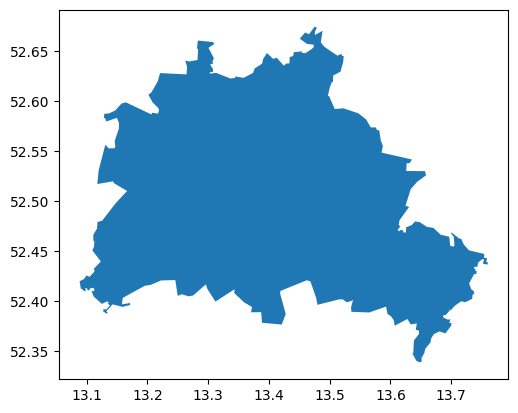

In [67]:
df[df['NAME_3']=='Berlin'].plot()

In [68]:
df.head(1)

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,DEU.1.1.1_1,DEU,Germany,DEU.1_1,Baden-Württemberg,NA,DEU.1.1_1,Alb-Donau-Kreis,NA,Allmendingen,NA,NA,Verwaltungsgemeinschaft,Municipality,084255001,NA,"MULTIPOLYGON (((9.82220 48.31950, 9.80970 48.3..."


In [69]:
df[df['NAME_3']=='Berlin'].total_bounds

array([13.0883, 52.3382, 13.7605, 52.6749])

## Target

In [70]:
y_df = pd.read_csv('../raw_data/0041478-230224095556074.csv', sep = '\t')

/var/folders/pr/mtx4wq4s043brx8dly3l_ybc0000gn/T/ipykernel_3944/3092844422.py:1: DtypeWarning: Columns (2,14,17,38,39,40,41,43,44,48) have mixed types. Specify dtype option on import or set low_memory=False.
  y_df = pd.read_csv('../raw_data/0041478-230224095556074.csv', sep = '\t')


In [71]:
y = y_df[['decimalLatitude', 'decimalLongitude', 'gbifID']]

In [72]:
y_geo = gpd.GeoDataFrame(y, geometry = gpd.points_from_xy(y['decimalLongitude'], y['decimalLatitude']), crs = 'epsg:4326')

In [73]:
y_geo.head(1)

,decimalLatitude,decimalLongitude,gbifID,geometry
0,52.547599,13.461955,2832407287,POINT (13.46195 52.54760)


In [74]:
y_geo.shape

(570147, 4)

<Axes: >

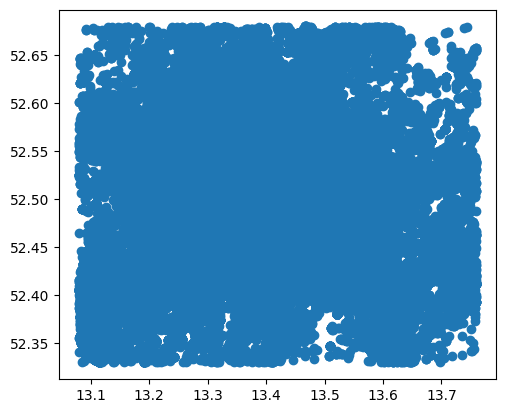

In [75]:
y_geo.plot()

In [12]:
count = gpd.sjoin(y_geo, df[df['NAME_3']=='Berlin']).shape

In [13]:
#fooling around
coords = [(0, 0), (0, 1), (1, 1), (1, 0)]
poly = Polygon(coords)
test_gdf = gpd.GeoDataFrame(geometry=[poly])
test_gdf

,geometry
0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1...."


In [14]:
gdf = df[df['NAME_3']=='Berlin']['geometry']
gdf

2028    MULTIPOLYGON (((13.50020 52.61380, 13.49680 52...
Name: geometry, dtype: geometry

# Grid Function

## Brain Storming

In [15]:
polygon = gpd.GeoDataFrame(df[df['NAME_3']=='Berlin']['geometry'])

In [16]:
#convert to meters
polygon_meter = polygon.set_crs(epsg=4326)  # Set the current CRS to WGS84
polygon_meter = polygon.to_crs(epsg=3035)  # Convert to the desired CRS (UTM zone 33N)

In [17]:
min_x, min_y, max_x, max_y = polygon_meter.bounds.values[0]

In [18]:
cell_size = 100  # Cell size in meters

In [19]:
num_cols = int((max_x - min_x) / cell_size)
num_rows = int((max_y - min_y) / cell_size)

In [20]:
from shapely.geometry import Polygon, Point

def create_square_polygon(size, centroid):
    half_size = size / 2
    x = centroid.x
    y = centroid.y
    points = [
        (x - half_size, y - half_size),
        (x + half_size, y - half_size),
        (x + half_size, y + half_size),
        (x - half_size, y + half_size)
    ]
    return Polygon(points)

In [21]:
polygons = []
for i in range(num_rows):
    for j in range(num_cols):
        x = min_x + j * cell_size + cell_size / 2
        y = min_y + i * cell_size + cell_size / 2
        centroid = Point(x, y)
        square = create_square_polygon(cell_size, centroid)
        #square = 2
        polygons.append(square)

In [22]:
grid = gpd.GeoDataFrame(geometry=polygons, crs='epsg:3035')
grid.head()

,geometry
0,"POLYGON ((4531039.698 3253860.913, 4531139.698..."
1,"POLYGON ((4531139.698 3253860.913, 4531239.698..."
2,"POLYGON ((4531239.698 3253860.913, 4531339.698..."
3,"POLYGON ((4531339.698 3253860.913, 4531439.698..."
4,"POLYGON ((4531439.698 3253860.913, 4531539.698..."


<Axes: >

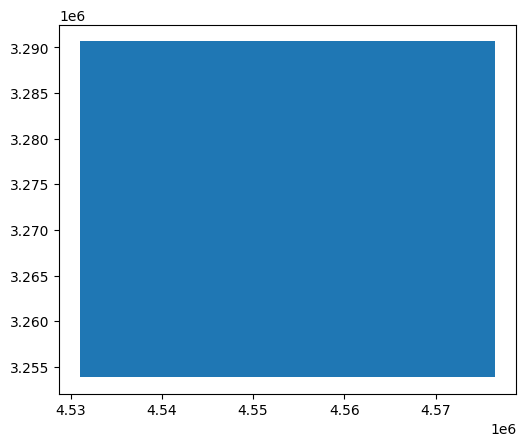

In [23]:
grid.plot()

<Axes: >

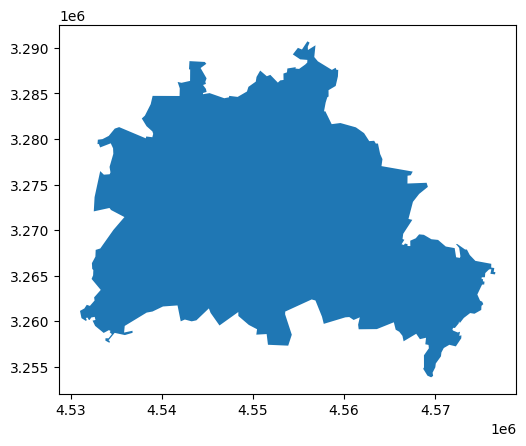

In [24]:
polygon_meter.plot()

In [25]:
grid_cut = gpd.sjoin(grid, polygon_meter)

<Axes: >

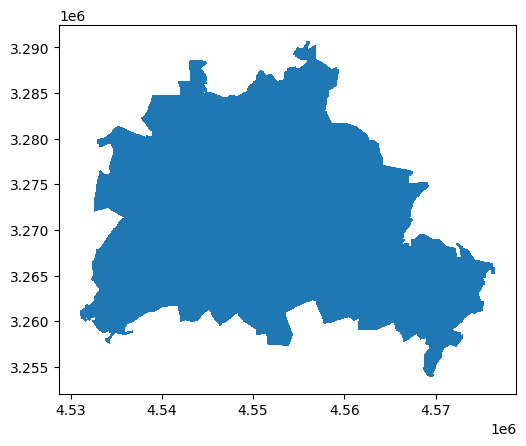

In [26]:
grid_cut.plot()

In [27]:
type(grid_cut)

geopandas.geodataframe.GeoDataFrame

In [28]:
grid_cut

,geometry,index_right
382,"POLYGON ((4569239.698 3253860.913, 4569339.698...",2028
383,"POLYGON ((4569339.698 3253860.913, 4569439.698...",2028
384,"POLYGON ((4569439.698 3253860.913, 4569539.698...",2028
385,"POLYGON ((4569539.698 3253860.913, 4569639.698...",2028
386,"POLYGON ((4569639.698 3253860.913, 4569739.698...",2028
...,...,...
166781,"POLYGON ((4556139.698 3290460.913, 4556239.698...",2028
167233,"POLYGON ((4555839.698 3290560.913, 4555939.698...",2028
167234,"POLYGON ((4555939.698 3290560.913, 4556039.698...",2028
167235,"POLYGON ((4556039.698 3290560.913, 4556139.698...",2028


In [29]:
grid_cut.iloc[3]['geometry'].area

10000.0

## Final

In [76]:
def create_square_polygon(size, centroid):
    half_size = size / 2
    x = centroid.x
    y = centroid.y
    points = [
        (x - half_size, y - half_size),
        (x + half_size, y - half_size),
        (x + half_size, y + half_size),
        (x - half_size, y + half_size)
    ]
    return Polygon(points)

def make_grid (polygon, cell_size):
    
    polygon_meter = polygon.set_crs(epsg=4326)  # Set the current CRS to WGS84
    polygon_meter = polygon.to_crs(epsg=3035)  # Convert to the desired CRS (UTM zone 33N)
    min_x, min_y, max_x, max_y = polygon_meter.bounds.values[0] #Retrieve extremes
    
    num_cols = int((max_x - min_x) / cell_size)
    num_rows = int((max_y - min_y) / cell_size)
    
    polygons = []
    for i in range(num_rows):
        for j in range(num_cols):
            x = min_x + j * cell_size + cell_size / 2
            y = min_y + i * cell_size + cell_size / 2
            centroid = Point(x, y)
            square = create_square_polygon(cell_size, centroid)
            polygons.append(square)
            
    grid = gpd.GeoDataFrame(geometry=polygons, crs='epsg:3035')
    grid_cut = gpd.sjoin(grid, polygon_meter)
    return grid_cut[['geometry']].reset_index(drop=True)

In [31]:
%%time
polygon_2 = gpd.GeoDataFrame(df[df['NAME_3']=='Berlin']['geometry'])
my_grid = make_grid(polygon_2, 6000)

CPU times: user 49.5 ms, sys: 3.22 ms, total: 52.7 ms
Wall time: 50.8 ms


In [32]:
type(polygon_2)

geopandas.geodataframe.GeoDataFrame

<Axes: >

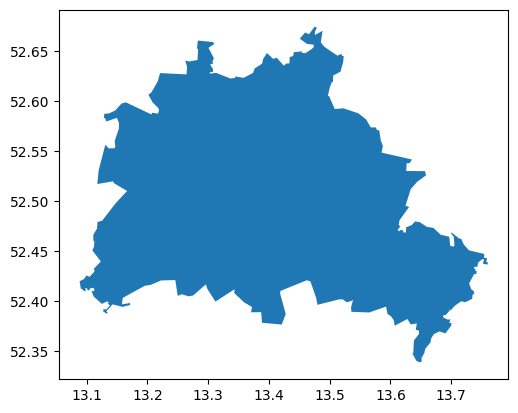

In [33]:
polygon_2.plot()

In [34]:
type(my_grid)

geopandas.geodataframe.GeoDataFrame

<Axes: >

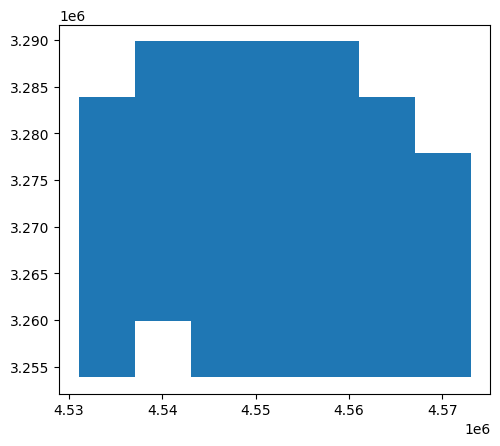

In [35]:
my_grid.plot()

In [36]:
my_grid.head(5)

,geometry
0,"POLYGON ((4531039.698 3253860.913, 4537039.698..."
1,"POLYGON ((4543039.698 3253860.913, 4549039.698..."
2,"POLYGON ((4549039.698 3253860.913, 4555039.698..."
3,"POLYGON ((4555039.698 3253860.913, 4561039.698..."
4,"POLYGON ((4561039.698 3253860.913, 4567039.698..."


# Target Map on Grid

## Research

In [37]:
y_geo

,decimalLatitude,decimalLongitude,gbifID,geometry
0,52.547599,13.461955,2832407287,POINT (13.46195 52.54760)
1,52.424582,13.096624,3906824794,POINT (13.09662 52.42458)
2,52.534192,13.389546,2836060223,POINT (13.38955 52.53419)
3,52.510258,13.347840,2832961073,POINT (13.34784 52.51026)
4,52.517157,13.407907,2839312403,POINT (13.40791 52.51716)
...,...,...,...,...
570142,52.401737,13.369331,922948989,POINT (13.36933 52.40174)
570143,52.434090,13.417997,920607467,POINT (13.41800 52.43409)
570144,52.548069,13.540564,3447345509,POINT (13.54056 52.54807)
570145,52.466469,13.488293,1899878384,POINT (13.48829 52.46647)


In [38]:
#make meter
y_meter = y_geo.set_crs(epsg=4326)  # Set the current CRS to WGS84
y_meter = y_geo.to_crs(epsg=3035)  # Convert to the desired CRS

In [39]:
y_meter = y_meter['geometry']

In [40]:
# Create a Shapely Polygon object from the polygon
polygon = my_grid.iloc[0]['geometry']

# Count the number of points in List A that are inside the polygon
num_points_inside = 0
for point in y_meter:
    if polygon.contains(Point(point)):
        num_points_inside += 1

print('Number of points inside the polygon:', num_points_inside)

Number of points inside the polygon: 4151


## assign_y (slow function)

In [41]:
# This is way too slow
def get_num_observations(polygon):
    num_points_inside = 0
    for point in y_meter:
        if polygon.contains(Point(point)):
            num_points_inside += 1
    return num_points_inside

In [42]:
box = my_grid.iloc[0]['geometry']
box_gpd = gpd.GeoSeries(box)

In [43]:
get_num_observations(my_grid.iloc[0]['geometry'])

4151

In [44]:
my_grid.head(2)

,geometry
0,"POLYGON ((4531039.698 3253860.913, 4537039.698..."
1,"POLYGON ((4543039.698 3253860.913, 4549039.698..."


In [45]:
my_grid['num_points_inside'] = my_grid.apply(lambda row: get_num_observations(row['geometry']), axis=1)

In [46]:
my_grid

,geometry,num_points_inside
0,"POLYGON ((4531039.698 3253860.913, 4537039.698...",4151
1,"POLYGON ((4543039.698 3253860.913, 4549039.698...",1177
2,"POLYGON ((4549039.698 3253860.913, 4555039.698...",9745
3,"POLYGON ((4555039.698 3253860.913, 4561039.698...",6037
4,"POLYGON ((4561039.698 3253860.913, 4567039.698...",2053
5,"POLYGON ((4567039.698 3253860.913, 4573039.698...",1599
6,"POLYGON ((4531039.698 3259860.913, 4537039.698...",4019
7,"POLYGON ((4537039.698 3259860.913, 4543039.698...",8322
8,"POLYGON ((4543039.698 3259860.913, 4549039.698...",10476
9,"POLYGON ((4549039.698 3259860.913, 4555039.698...",87102


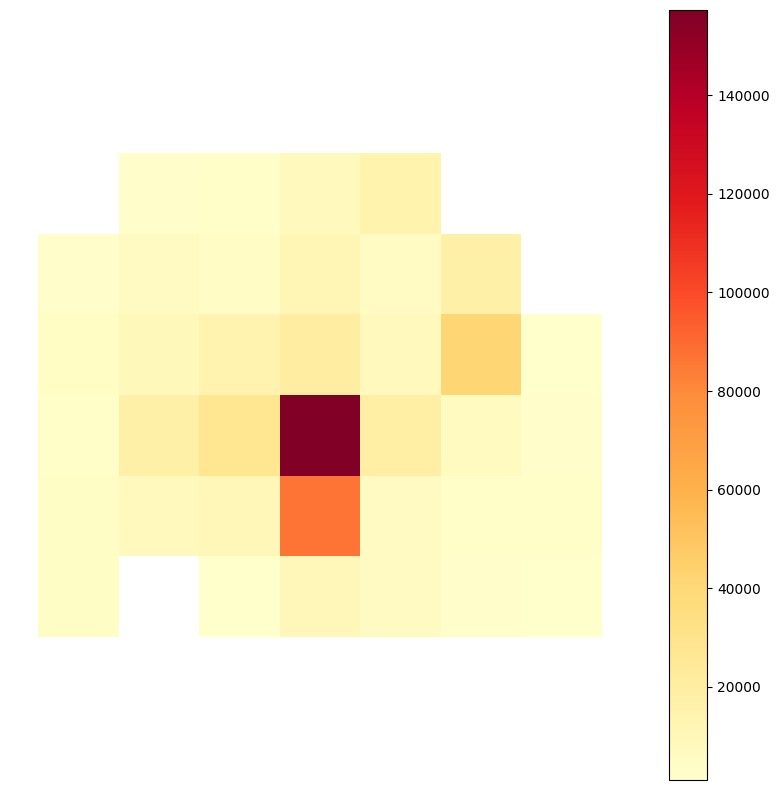

In [47]:
# Load the GeoDataFrame containing the polygons and the number of points inside each polygon
#gdf = gpd.read_file('polygons.shp')
#gdf = gdf.to_crs(epsg=3857)  # Convert to Web Mercator projection

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
my_grid.plot(column='num_points_inside', cmap='YlOrRd', ax=ax, legend=True)
ax.set_axis_off()
plt.show()

## assign_y (fast function)

In [77]:
def count_points(polygon, y_meter_data):
    
    #write Square to GeoDataFrame
    polygon_gs = gpd.GeoSeries([polygon])
    polygon_gpd = gpd.GeoDataFrame(geometry = polygon_gs)
    
    #To avoid error message, assert in assign_y makes sure this is true
    polygon_gpd.crs = 'epsg:3035'
    y_meter_data.crs = 'epsg:3035'
    
    # Perform a spatial join to get the points inside the polygon
    gdf_join = gpd.sjoin(y_meter_data, polygon_gpd)

    # Count the number of points inside the polygon
    return len(gdf_join)

def assign_y(grid, y_meter_data):
    
    # Check Inputs
    crs = 'epsg:3035'
    assert grid.crs == crs, f'CRS mismatch: expected {crs}, got {gdf.crs}'
    assert y_meter.crs == crs, f'CRS mismatch: expected {crs}, got {gdf.crs}'
    assert isinstance(grid, gpd.GeoDataFrame), f'Expected GeoDataFrame, got {type(gdf)}'
    assert isinstance(y_meter_data, gpd.GeoDataFrame), f'Expected GeoDataFrame, got {type(gdf)}'
    
    grid['num_points_inside'] = grid.apply(lambda row: count_points(row['geometry'], y_meter_data), axis=1)
    
    return grid

In [52]:
%%time
city_polygon = gpd.GeoDataFrame(df[df['NAME_3']=='Berlin']['geometry']) #Get Polygon of City
city_grid = make_grid(polygon_2, 1000) # Make grid
y_meter_gpd = gpd.GeoDataFrame(geometry = y_meter) #Load y
city_grid_y = assign_y(city_grid, y_meter_gpd) #Assign y

CPU times: user 2min 5s, sys: 2.19 s, total: 2min 8s
Wall time: 2min 8s


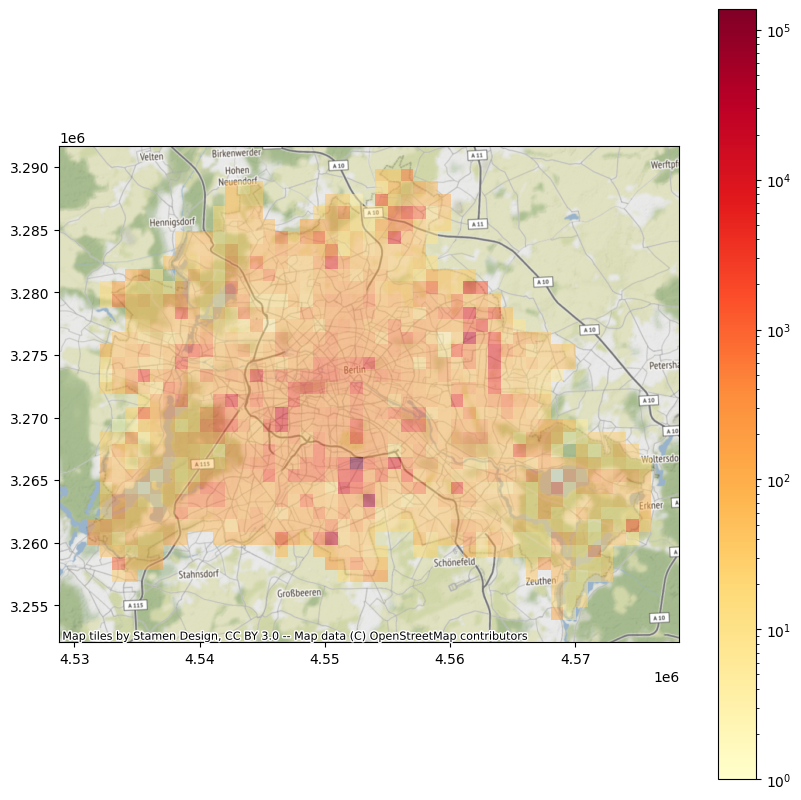

In [53]:
import contextily as cx
import matplotlib.colors as colors

# Set the minimum and maximum values for the color map
vmin = city_grid_y['num_points_inside'].min()
vmax = city_grid_y['num_points_inside'].max()

#Create a log scale color map
cmap = 'YlOrRd'
norm = colors.LogNorm(vmin=vmin+1, vmax=vmax-1) #+/-1 required

# Plot the data with the log scale color map
fig, ax = plt.subplots(figsize=(10,10))
city_grid_y.plot(column='num_points_inside', cmap=cmap, norm=norm, ax=ax, legend=True, alpha = 0.5)
cx.add_basemap(ax, crs = city_grid_y.crs)

## Assign Urban Atlas

### Data Import

In [78]:
import geopandas as gpd

# path to the GeoPackage file
gpkg_path = '../raw_data/urban_atlas.gpkg'

# read the GeoPackage file into a GeoDataFrame
X_ua = gpd.read_file(gpkg_path)

<Axes: >

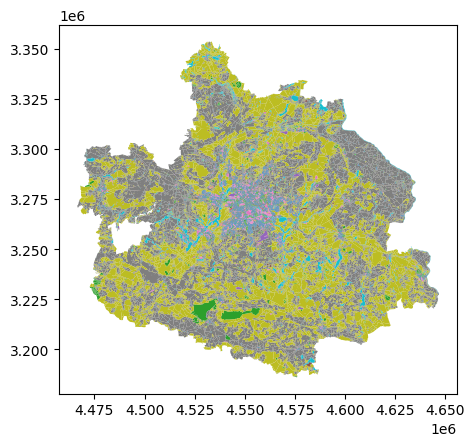

In [79]:
X_ua.plot(column = 'code_2018')

In [146]:
polygon_5 = gpd.GeoDataFrame(df[df['NAME_3']=='Berlin']['geometry']) #Get Polygon of City
city_grid = make_grid(polygon_5, 100) # Make grid

In [89]:
type(city_grid)

geopandas.geodataframe.GeoDataFrame

### Compare join

In [129]:
#Crop poly
X_ua_crop_poly = gpd.sjoin(X_ua, polygon_5.to_crs(epsg=3035), predicate = 'overlaps')

<Axes: >

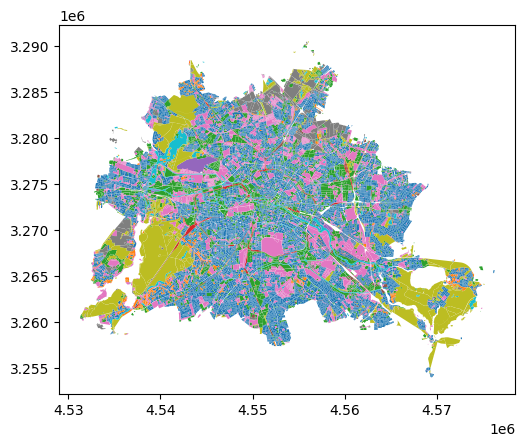

In [100]:
X_ua_crop_poly.plot(column = 'code_2018')

In [64]:
city_grid['urban_atlas'] = grid.apply(lambda row: count_points(row['geometry'], y_meter_data), axis=1)

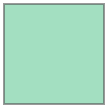

In [177]:
example = city_grid.iloc[999]['geometry']
example

In [178]:
temp_gdf = gpd.GeoDataFrame(geometry=[example])
temp_gdf.crs = 'epsg:3035'

In [161]:
temp_assign_X_within = gpd.sjoin(X_ua, temp_gdf,  predicate = 'within')

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Axes: >

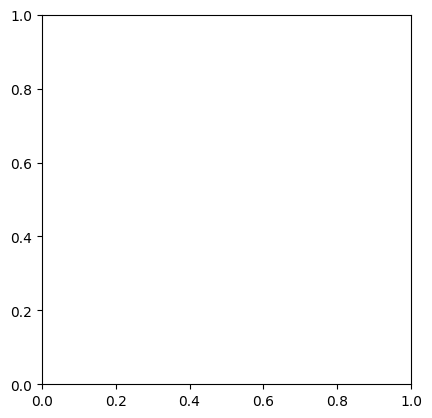

In [162]:
temp_assign_X_within.plot(column = 'code_2018')

In [163]:
temp_assign_X_within.shape

(0, 13)

In [179]:
temp_assign_X_overlaps = gpd.sjoin(X_ua, temp_gdf,  predicate = 'intersects')

<Axes: >

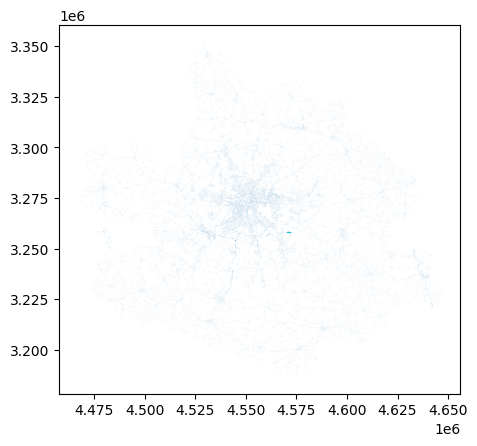

In [180]:
ax = temp_assign_X_overlaps.plot(column='code_2018')
#ax.set_xlim([4550000, 4560000])
#ax.set_ylim([3285000, 3290000])
temp_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

In [191]:
int(temp_assign_X_overlaps.iloc[0]['code_2018'])

12220

### Create Function

In [210]:
def get_ua_on_square(polygon, urban_atlas):
    polygon_gdf = gpd.GeoDataFrame(geometry=[polygon])
    polygon_gdf.crs = 'epsg:3035'
    
    overlap_gdf = gpd.sjoin(urban_atlas, polygon_gdf,  predicate = 'intersects')
    
    if overlap_gdf.shape[0] == 0:
        print('No overlap in get_ua_on_square') 
        return 0
    elif overlap_gdf.shape[0] == 1:
        return int(overlap_gdf.iloc[0]['code_2018'])
    else:
        return int(overlap_gdf.iloc[0]['code_2018']) # This part lacks accuracy
    
    

def get_urban_atlas(polygon, grid, urban_atlas):
    
    crs = 'epsg:3035'
    assert grid.crs == crs, f'CRS mismatch: expected {crs}, got {gdf.crs}'
    assert urban_atlas.crs == crs, f'CRS mismatch: expected {crs}, got {gdf.crs}'
    assert isinstance(grid, gpd.GeoDataFrame), f'Expected GeoDataFrame, got {type(gdf)}'
    assert isinstance(urban_atlas, gpd.GeoDataFrame), f'Expected GeoDataFrame, got {type(gdf)}'
    
    grid['urban_atlas'] = grid.apply(lambda row: get_ua_on_square(row['geometry'], urban_atlas), axis=1)
    
    return grid

In [251]:
# Load arguments
gpkg_path = '../raw_data/urban_atlas.gpkg'
urban_atlas = gpd.read_file(gpkg_path)
polygon = gpd.GeoDataFrame(df[df['NAME_3']=='Berlin']['geometry']) #Get Polygon of City

In [252]:
urban_atlas.shape

(120828, 12)

In [253]:
city_grid = make_grid(polygon, 4000) # Make grid

In [254]:
%%time
grid_urban_atlas = get_urban_atlas(polygon, city_grid, urban_atlas)

CPU times: user 1min 1s, sys: 15 s, total: 1min 16s
Wall time: 1min 16s


<Axes: >

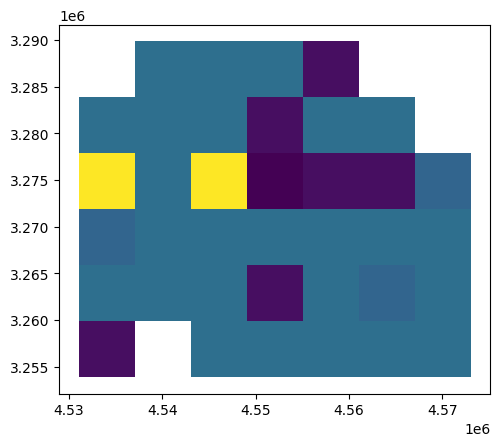

In [224]:
grid_urban_atlas.plot(column='urban_atlas')

In [ ]:
# Attempt to make faster. Failed as code does not compile
import multiprocessing as mp

def get_urban_atlas_parallel(grid, urban_atlas, num_processes=4):
    pool = mp.Pool(num_processes)
    results = pool.map(lambda row: get_ua_on_square(row['geometry'], urban_atlas), grid.to_dict('records'))
    pool.close()
    grid['urban_atlas'] = results
    return grid

## Assign Tree Layer

In [230]:
gpkg_path_tree = '../raw_data/tree_layer.gpkg'
tree_layer = gpd.read_file(gpkg_path_tree)

In [231]:
# Randomly select 5000 rows from the GeoDataFrame
sample_tree = tree_layer.sample(n=20000, random_state=1)

In [240]:
sample_tree = sample_tree.to_crs(epsg=3035)

<Axes: >

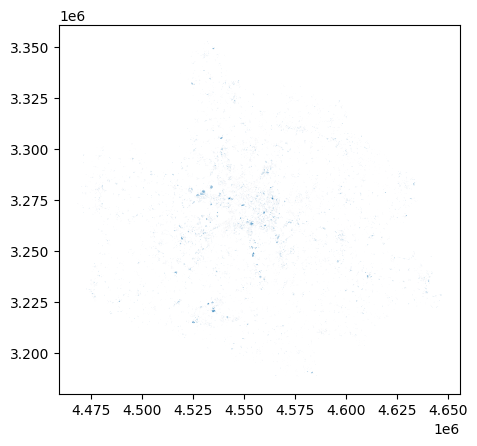

In [241]:
sample_tree.plot()

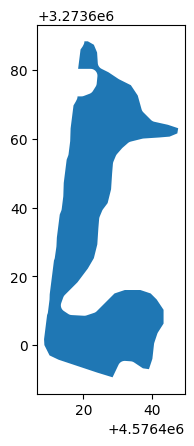

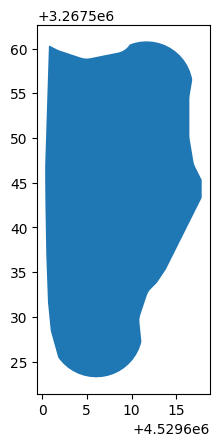

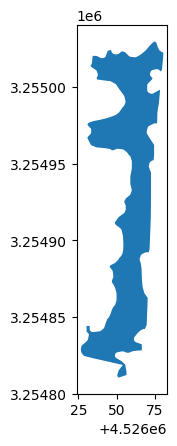

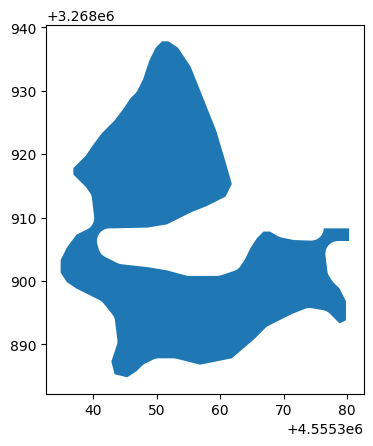

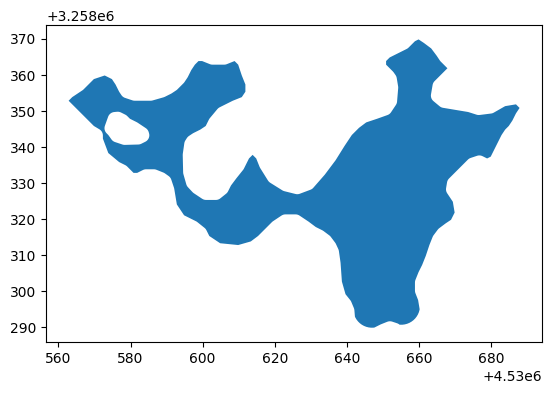

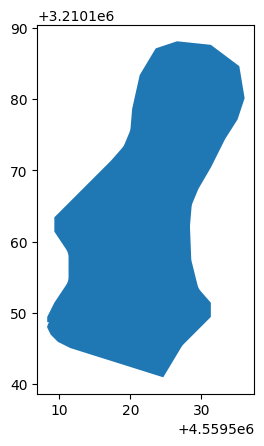

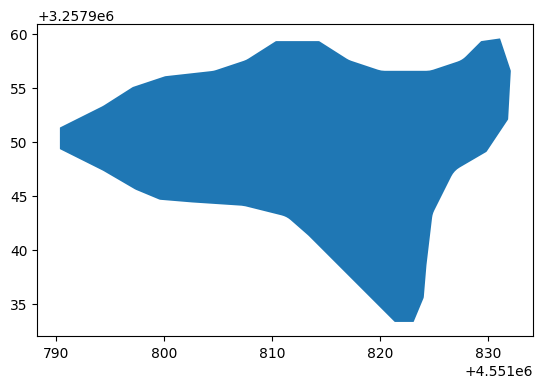

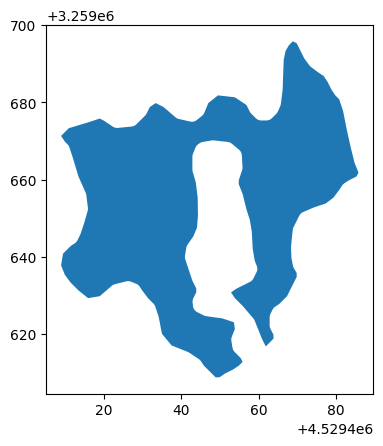

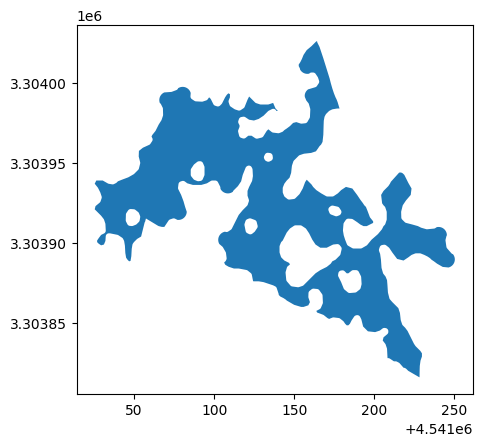

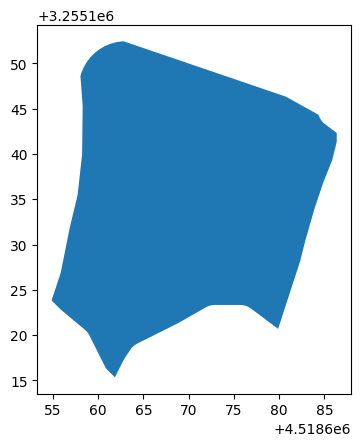

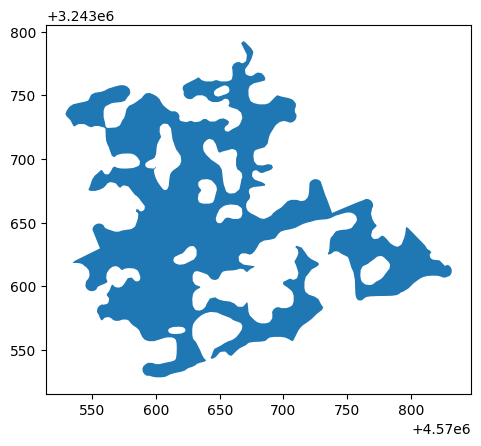

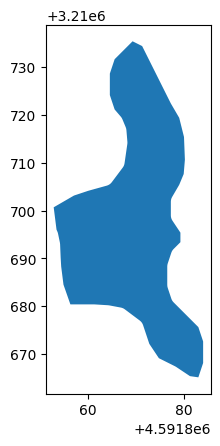

In [242]:
for i in range(12):
    sample_tree.iloc[i:i+1].plot()
    plt.show()

In [247]:
import geopandas as gpd
from shapely.geometry import mapping, shape